# # Model Training Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Initial Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Load the preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/Crime_Dataset/lapd_clean_model_ready.csv", low_memory=False)

In [ ]:
# Inspect the preprocessed dataset
# Note: Some categorical features remain unencoded, as LightGBM supports native categorical handling
df.head()


,area,part,victim_sex,victim_descent,hour,day_of_week,month,crime_category,geo_cluster,victim_age_group,mo_present,mo_code_count,premise_code_grouped,weapon_group,weapon_used,status_encoded
0,15,2,Male,H,8,5,11,Theft & Fraud,8,Adult (25-44),1,1,501.0,Unknown,0,1
1,15,1,Male,H,18,6,10,Violent Assault,13,Adult (25-44),1,8,102.0,Sharp Weapon,1,1
2,9,2,Male,W,12,4,10,Theft & Fraud,13,Adult (25-44),1,1,501.0,Unknown,0,1
3,7,1,Female,A,13,3,12,Theft & Fraud,0,Middle Aged (45-64),1,1,101.0,Unknown,0,1
4,14,1,Male,H,18,1,9,Theft & Fraud,12,Middle Aged (45-64),1,4,Other,Unknown,0,1


In [ ]:
# preprocessed data shape
df.shape

(1003008, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003008 entries, 0 to 1003007
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   area                  1003008 non-null  int64 
 1   part                  1003008 non-null  int64 
 2   victim_sex            1003008 non-null  object
 3   victim_descent        1003008 non-null  object
 4   hour                  1003008 non-null  int64 
 5   day_of_week           1003008 non-null  int64 
 6   month                 1003008 non-null  int64 
 7   crime_category        1003008 non-null  object
 8   geo_cluster           1003008 non-null  int64 
 9   victim_age_group      1003008 non-null  object
 10  mo_present            1003008 non-null  int64 
 11  mo_code_count         1003008 non-null  int64 
 12  premise_code_grouped  1003008 non-null  object
 13  weapon_group          1003008 non-null  object
 14  weapon_used           1003008 non-null  int64 
 15

Categorical variables are not explicitly encoded prior to training, as LightGBM natively supports categorical features. Providing these features directly allows the model to learn optimal category splits internally, avoiding unnecessary dimensionality expansion and improving computational efficiency.

# Training LightGBM on raw Imbalanced Dataset

In [ ]:
# Create a clean LightGBM modeling dataframe
df_lgb = df.copy()

In [ ]:
# Specify categorical features to leverage LightGBM's native categorical handling
categorical_cols = [
    'victim_sex',
    'victim_descent',
    'crime_category',
    'victim_age_group',
    'premise_code_grouped',
    'weapon_group'
]

# Convert selected features to categorical dtype
# LightGBM uses this information to perform optimal categorical splits
for col in categorical_cols:
    df_lgb[col] = df_lgb[col].astype('category')

In [ ]:
# Separate input features and target variable
TARGET = 'status_encoded'
X_lgb = df_lgb.drop(columns=[TARGET])
y_lgb = df_lgb[TARGET]

In [ ]:
# Perform stratified train–test split
# Stratification preserves the original class distribution under imbalance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_lgb,
    y_lgb,
    test_size=0.2,
    random_state=42,
    stratify=y_lgb
)



In [ ]:
# Compute class imbalance ratio for cost-sensitive learning
# This penalizes misclassification of the minority class during training
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

In [ ]:
# Initialize baseline LightGBM classifier
# Parameters are chosen to balance model capacity and generalization
import lightgbm as lgb

lgb_baseline = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Train the model using native categorical feature support
lgb_baseline.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)


[LightGBM] [Info] Number of positive: 642217, number of negative: 160189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 802406, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800364 -> initscore=1.388572
[LightGBM] [Info] Start training from score 1.388572


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               n_jobs=-1, objective='binary', random_state=42,
               scale_pos_weight=np.float64(0.24943126700165208), subsample=0.8)

In [ ]:
# Generate class predictions on the test set
y_pred = lgb_baseline.predict(X_test)

# Generate predicted probabilities for the positive class
# Used for threshold-independent evaluation metrics
y_proba = lgb_baseline.predict_proba(X_test)[:, 1]


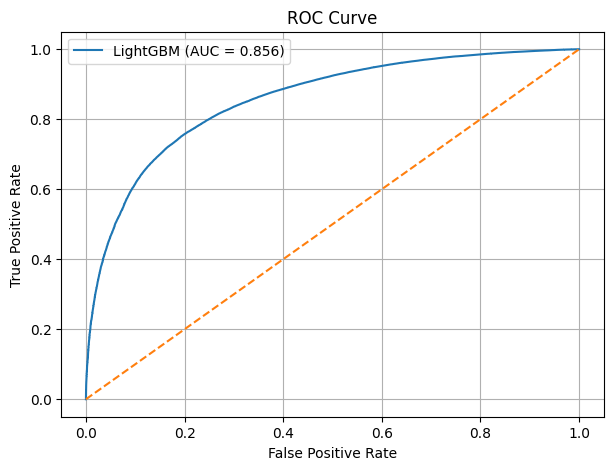

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


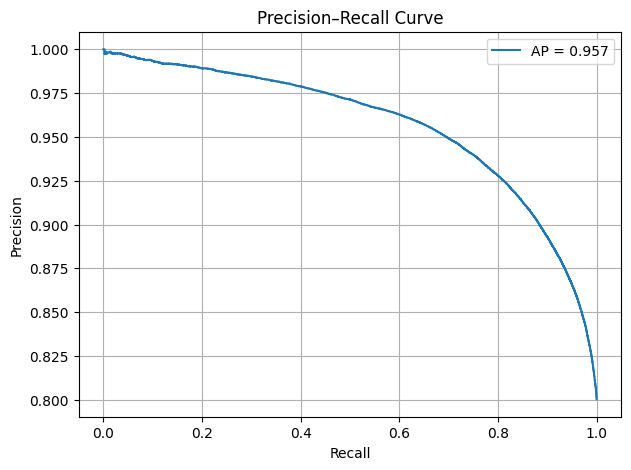

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Plot PR curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


The learning curve uses internal cross-validation at each training size, where validation performance is computed on held-out folds rather than a separate validation set

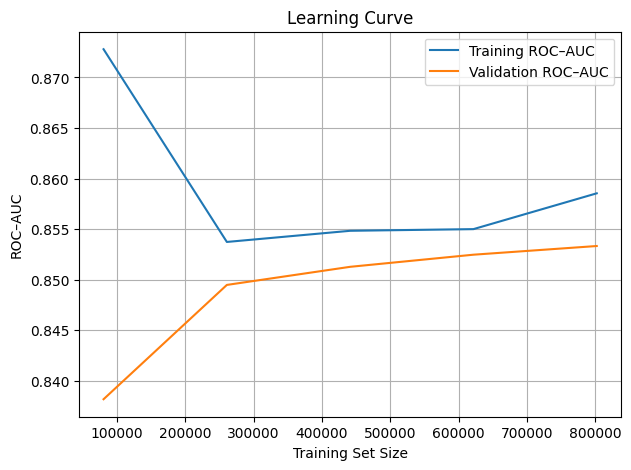

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    lgb_baseline,
    X_lgb,
    y_lgb,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Compute means
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, label='Training ROC–AUC')
plt.plot(train_sizes, val_mean, label='Validation ROC–AUC')
plt.xlabel('Training Set Size')
plt.ylabel('ROC–AUC')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


The convergence of training and validation ROC–AUC indicates good generalization with no evidence of overfitting. Performance gains saturate beyond ~600k samples, suggesting diminishing returns from additional data.

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# 1. Standard Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# 2. Calculate ROC AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.45      0.80      0.58     40047
     Class 1       0.94      0.76      0.84    160555

    accuracy                           0.77    200602
   macro avg       0.70      0.78      0.71    200602
weighted avg       0.84      0.77      0.79    200602

ROC AUC Score: 0.8564


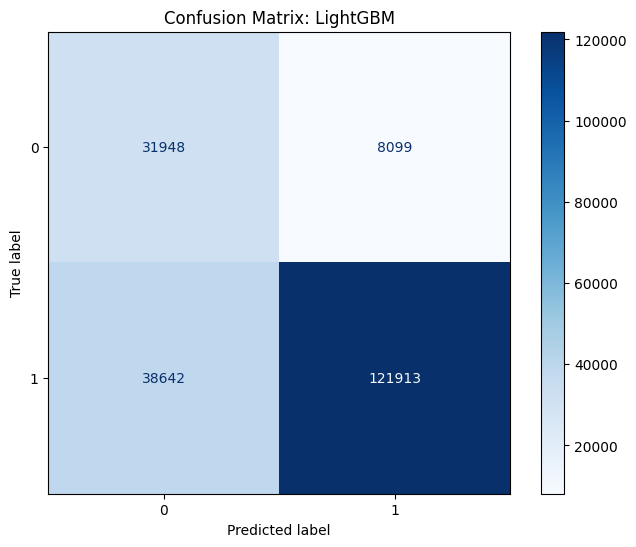

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_baseline.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix: LightGBM')
plt.grid(False) # Matrix plots look better without the grid lines
plt.show()

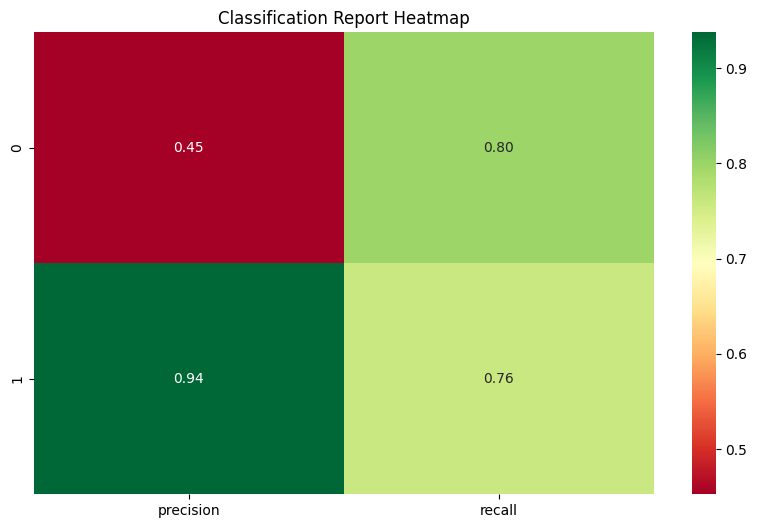

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report

# 1. Generate report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# 2. Convert to DataFrame
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T

# 3. Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, cmap='RdYlGn', fmt='.2f')

plt.title('Classification Report Heatmap')
plt.show()

**SHAP Interpretability**

In [ ]:
import shap

# Use TreeExplainer for LightGBM models
explainer = shap.TreeExplainer(lgb_baseline)
shap_values = explainer.shap_values(X_test)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


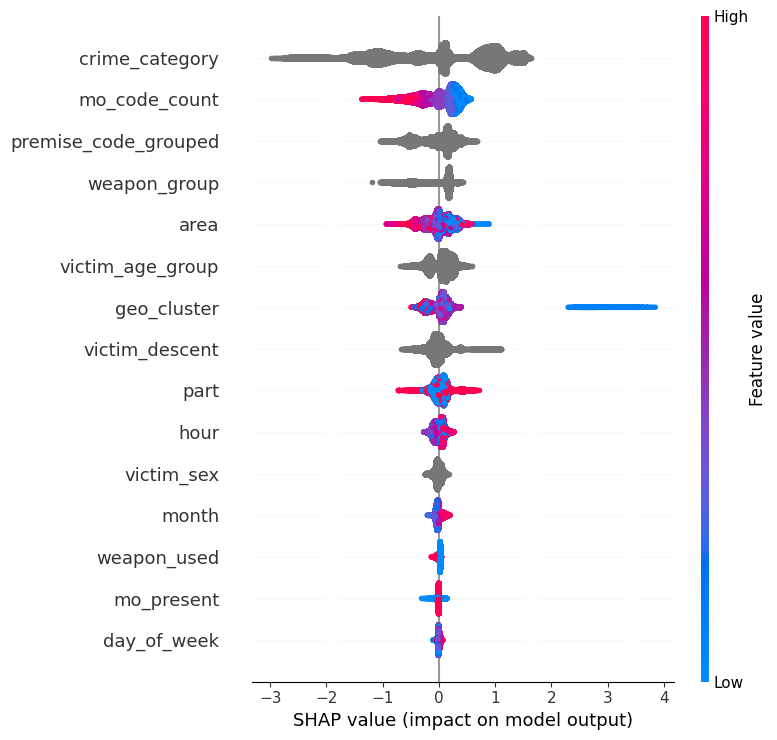

In [ ]:
# SHAP summary plot (global importance)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type='dot',
    show=True
)


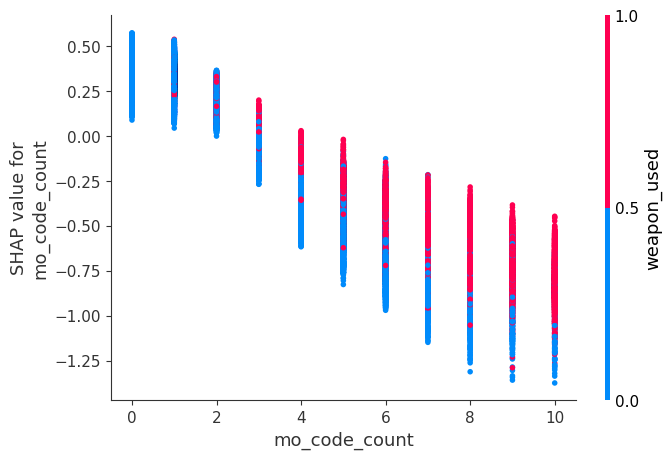

In [ ]:
# SHAP dependence plot for a top feature
shap.dependence_plot(
    'mo_code_count',
    shap_values,
    X_test,
    show=True
)


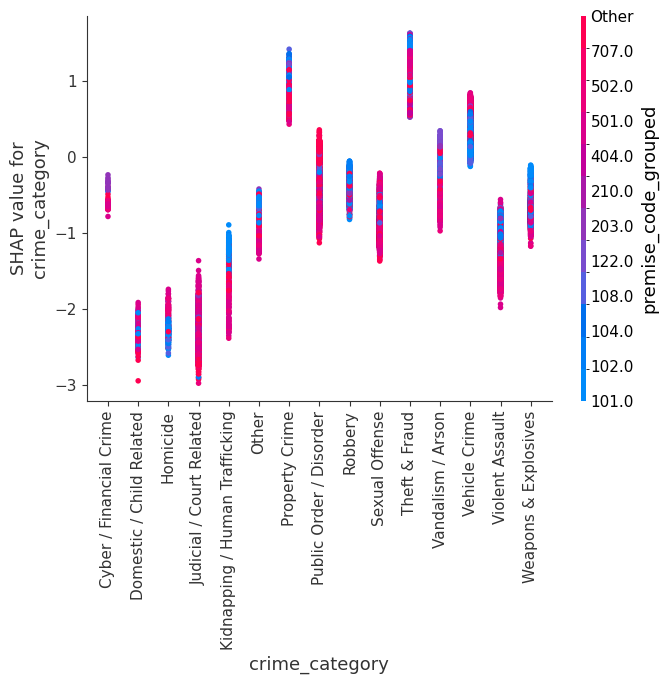

In [ ]:
# Shap dependence plot
shap.dependence_plot(
    "crime_category",
    shap_values,
    X_test
)

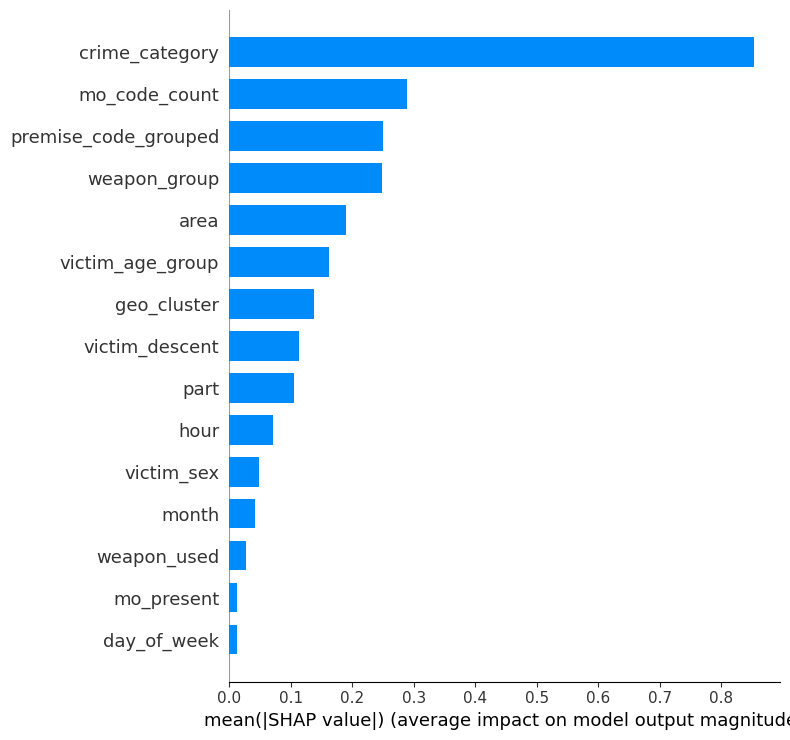

In [ ]:
# Shap Bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

<Figure size 2400x200 with 0 Axes>

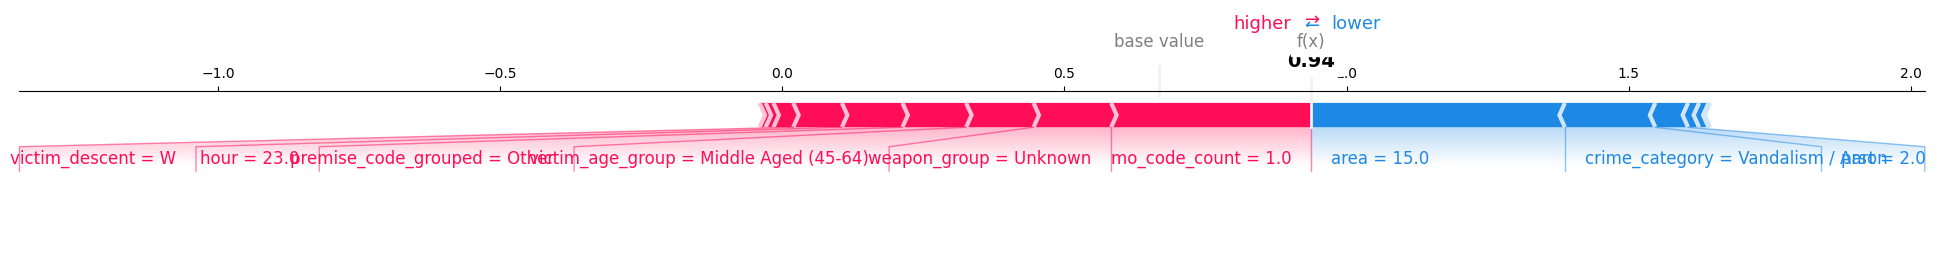

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 2))

shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    matplotlib=True,
    show=False # Prevent double plotting
)

plt.tight_layout()
plt.show()

# #Optimized LightGBM

In [ ]:
# imports
!pip install optuna

import optuna
from sklearn.model_selection import StratifiedKFold

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Defining Objective Function (5-Fold CV)
def objective(trial):

    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": 42,
        "n_jobs": -1,

        # Hyperparameters to tune
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),

        # Imbalance handling
        "scale_pos_weight": scale_pos_weight
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):

        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            categorical_feature=categorical_cols
        )

        y_val_proba = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_val_proba))

    return np.mean(auc_scores)


In [ ]:
# running Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best CV ROC-AUC:", study.best_value)
print("\nBest Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2026-02-07 13:28:06,306] A new study created in memory with name: no-name-6bb419bb-0a22-47e0-8247-ee43bf6cf36f
[I 2026-02-07 13:31:43,369] Trial 0 finished with value: 0.8583575243745614 and parameters: {'learning_rate': 0.05759441190804641, 'num_leaves': 129, 'max_depth': 11, 'min_child_samples': 52, 'subsample': 0.8656880012994028, 'colsample_bytree': 0.7575339152998298, 'reg_alpha': 3.363696637335833, 'reg_lambda': 3.351721275948709, 'n_estimators': 246}. Best is trial 0 with value: 0.8583575243745614.
[I 2026-02-07 13:34:20,895] Trial 1 finished with value: 0.8579829276715192 and parameters: {'learning_rate': 0.093457615767629, 'num_leaves': 58, 'max_depth': 9, 'min_child_samples': 137, 'subsample': 0.7134132456618553, 'colsample_bytree': 0.6380325978352538, 'reg_alpha': 1.7379369407026561, 'reg_lambda': 0.7174069866060739, 'n_estimators': 336}. Best is trial 0 with value: 0.8583575243745614.
[I 2026-02-07 13:35:35,534] Trial 2 finished with value: 0.8356330661840445 and paramet

Best CV ROC-AUC: 0.8590865524084835

Best Parameters:
learning_rate: 0.07135275647891208
num_leaves: 124
max_depth: 12
min_child_samples: 185
subsample: 0.6186994545170178
colsample_bytree: 0.6378487774807965
reg_alpha: 3.467925968493809
reg_lambda: 1.2210309010380014
n_estimators: 557


In [ ]:
import lightgbm as lgb

# Use your best parameters here
best_params = {
    "learning_rate":  0.07135275647891208,
    "num_leaves": 124,
    "max_depth": 12,
    "min_child_samples": 185,
    "subsample": 0.6186994545170178,
    "colsample_bytree": 0.6378487774807965,
    "reg_alpha":3.467925968493809,
    "reg_lambda": 1.2210309010380014,
    "n_estimators": 557
}

lgb_optimized = lgb.LGBMClassifier(
    objective="binary",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    **best_params
)


In [ ]:
# Training Final Optimized Model
lgb_optimized.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)



[LightGBM] [Info] Number of positive: 642217, number of negative: 160189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 802406, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800364 -> initscore=1.388572
[LightGBM] [Info] Start training from score 1.388572


LGBMClassifier(colsample_bytree=0.6378487774807965,
               learning_rate=0.07135275647891208, max_depth=12,
               min_child_samples=185, n_estimators=557, n_jobs=-1,
               num_leaves=124, objective='binary', random_state=42,
               reg_alpha=3.467925968493809, reg_lambda=1.2210309010380014,
               scale_pos_weight=np.float64(0.24943126700165208),
               subsample=0.6186994545170178)

In [ ]:
# predicting
y_pred = lgb_optimized.predict(X_test)
y_proba = lgb_optimized.predict_proba(X_test)[:, 1]



In [ ]:
# classification report
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.79      0.59     40047
           1       0.94      0.77      0.85    160555

    accuracy                           0.78    200602
   macro avg       0.70      0.78      0.72    200602
weighted avg       0.84      0.78      0.79    200602



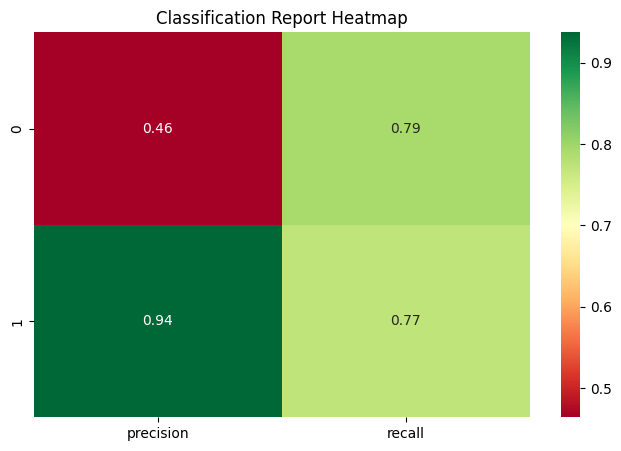

In [ ]:
import seaborn as sns
import pandas as pd

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T

plt.figure(figsize=(8,5))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Classification Report Heatmap")
plt.show()


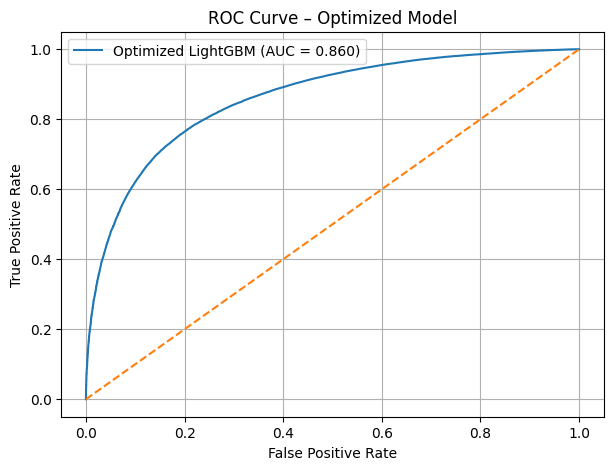

Optimized ROC-AUC: 0.8604


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Optimized LightGBM (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Optimized Model")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimized ROC-AUC: {roc_auc:.4f}")


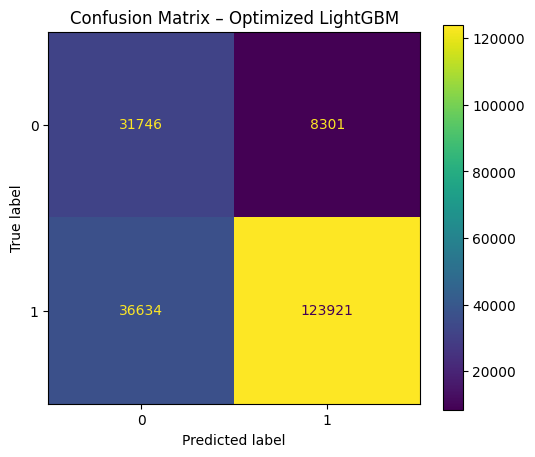

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, values_format='d')
plt.title("Confusion Matrix – Optimized LightGBM")
plt.grid(False)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Manually extracted CV ROC-AUC values from your trials
cv_results = [
0.8583575243745614,
0.8579829276715192,
0.8356330661840445,
0.855773121604317,
0.8584815895825617,
0.8553230367710473,
0.8544380737417328,
0.8586166418906662,
0.8544174972027854,
0.8587919116676298,
0.8587785834763016,
0.8588077097866554,
0.8590006711750977,
0.8584038720652204,
0.8589307935740795,
0.858892946523785,
0.8577710672417096,
0.8565280826674379,
0.8583521196243227,
0.855141049387956,
0.8528733560177171,
0.8588347412392372,
0.8589912495384745,
0.85904977033322,
0.8589482336321141,
0.8589033133779314,
0.858978813937312,
0.8585569523807818,
0.8584663069636129,
0.8588651272622151,
0.8586262366881339,
0.8588394257885877,
0.8588474922456981,
0.8588924487062333,
0.858574958177789,
0.8589394050969444,
0.8589984718379382,
0.8581776663323893,
0.8569690602844868,
0.8579806340094585,
0.8568470235191334,
0.8590006557908069,
0.8588409068516935,
0.8590343143880809,
0.8590865524084835,
0.85899999387908,
0.8589034209089641,
0.8586126870720161,
0.8517227471068292,
0.8582477788809832
]


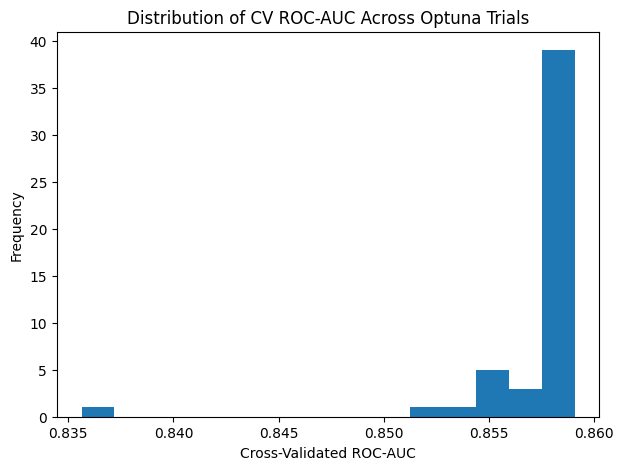

In [ ]:
# Plot CV AUC Distribution
plt.figure(figsize=(7,5))
plt.hist(cv_results, bins=15)
plt.xlabel("Cross-Validated ROC-AUC")
plt.ylabel("Frequency")
plt.title("Distribution of CV ROC-AUC Across Optuna Trials")
plt.show()



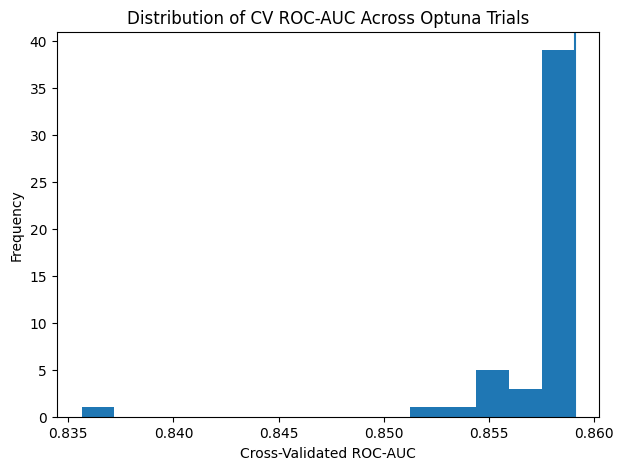

In [ ]:
# Best value line
best_auc = 0.8590865524084835

plt.figure(figsize=(7,5))
plt.hist(cv_results, bins=15)
plt.axvline(best_auc)
plt.xlabel("Cross-Validated ROC-AUC")
plt.ylabel("Frequency")
plt.title("Distribution of CV ROC-AUC Across Optuna Trials")
plt.show()


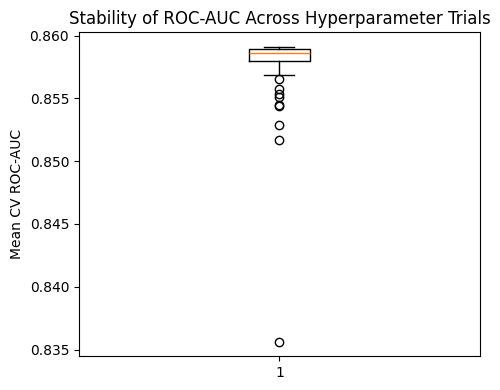

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.boxplot(cv_results, vert=True)
plt.ylabel("Mean CV ROC-AUC")
plt.title("Stability of ROC-AUC Across Hyperparameter Trials")
plt.tight_layout()
plt.show()


**Imbalance Sensitive LightGBM and Feature Corleation Matrix**

In [ ]:
import lightgbm as lgb
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)


In [ ]:
def train_lgb_imbalance_sensitive(X_train, y_train, categorical_cols,
                                  n_estimators=300, learning_rate=0.05, num_leaves=31):
    """
    Train LightGBM with automatic class weights to handle imbalance.
    """
    # Compute class weights (inverse frequency)
    counter = Counter(y_train)
    total = sum(counter.values())
    class_weight = {cls: total/count for cls, count in counter.items()}
    print("Class weights applied:", class_weight)

    # Initialize model
    model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight=class_weight,  # <-- handle imbalance
        random_state=42,
        n_jobs=-1
    )

    # Fit model
    model.fit(
        X_train,
        y_train,
        categorical_feature=categorical_cols
    )

    return model


In [ ]:
lgb_imbalance_sensitive = train_lgb_imbalance_sensitive(
    X_train, y_train, categorical_cols
)


Class weights applied: {1: 1.249431267001652, 0: 5.009120476437208}


In [ ]:
def plot_feature_correlation(df, categorical_cols):
    """
    Plot correlation matrix to detect redundant features.
    Categorical features are converted to codes for correlation calculation.
    """
    df_encoded = df.copy()
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].cat.codes

    corr_matrix = df_encoded.corr()

    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title("Feature Correlation Matrix")
    plt.show()

    return corr_matrix


In [ ]:
def evaluate_lgb_model(model, X_val, y_val):
    """
    Evaluate LightGBM model performance:
    - Confusion matrix
    - Classification report (precision, recall, F1)
    - ROC AUC
    - ROC Curve plot
    """
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    # Precision, Recall, F1
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

    # ROC AUC
    auc = roc_auc_score(y_val, y_pred_proba)
    print(f"ROC AUC: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})', color='darkorange', lw=2)
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for lgb_imbalance_sensitive')
    plt.legend(loc="lower right")
    plt.show()


This is for plot of comparison of confusion matirx

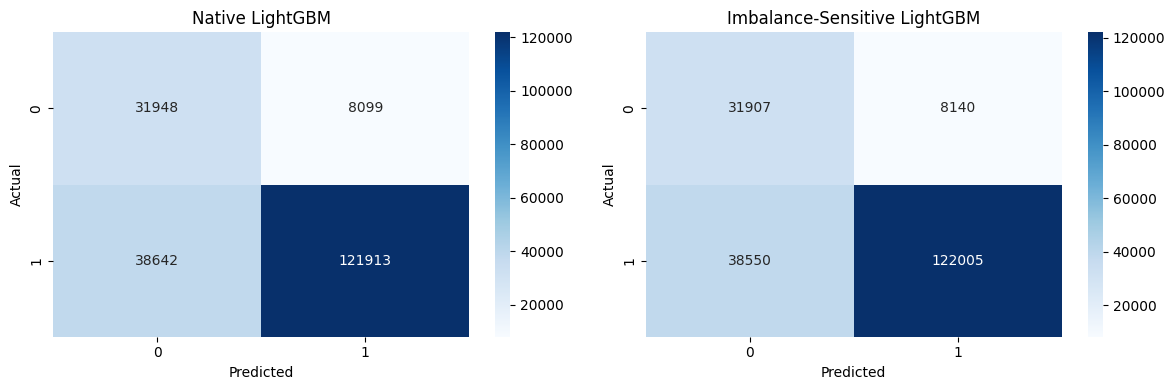

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_baseline = lgb_baseline.predict(X_test)
y_pred_imbalance = lgb_imbalance_sensitive.predict(X_test)

# Confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_imbalance = confusion_matrix(y_test, y_pred_imbalance)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    ax=axes[0],
    cmap="Blues"
)
axes[0].set_title("Native LightGBM")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    cm_imbalance,
    annot=True,
    fmt="d",
    ax=axes[1],
    cmap="Blues"
)
axes[1].set_title("Imbalance-Sensitive LightGBM")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


Confusion Matrix:
 [[ 31907   8140]
 [ 38550 122005]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.80      0.58     40047
           1       0.94      0.76      0.84    160555

    accuracy                           0.77    200602
   macro avg       0.70      0.78      0.71    200602
weighted avg       0.84      0.77      0.79    200602

Precision: 0.9375 | Recall: 0.7599 | F1 Score: 0.8394
ROC AUC: 0.8564


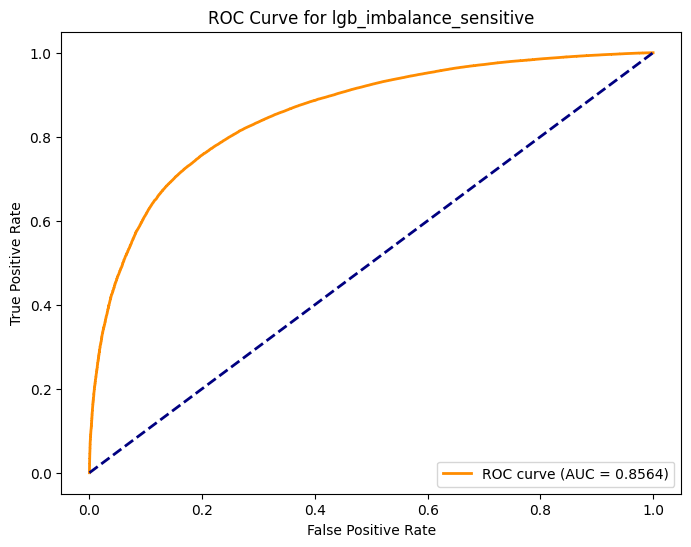

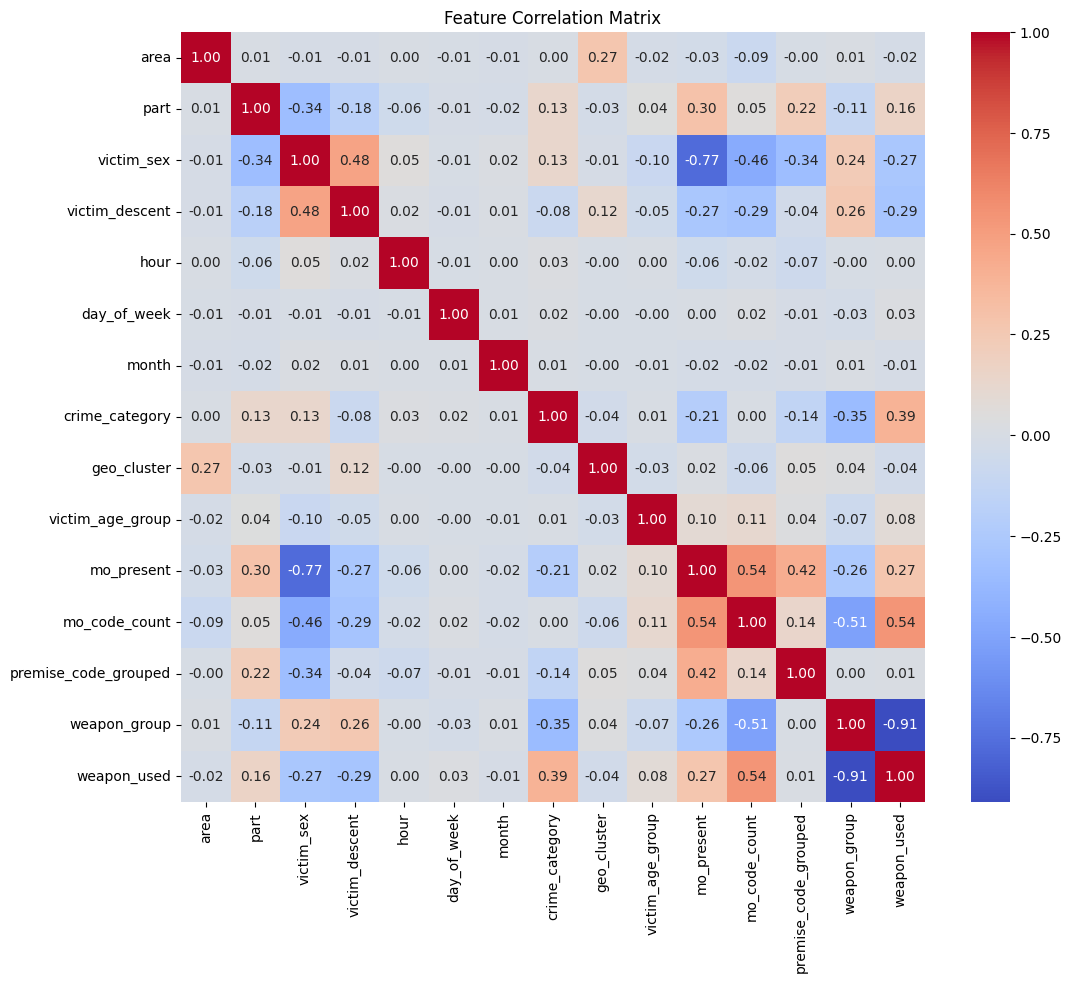

In [ ]:
# Evaluate model
evaluate_lgb_model(lgb_imbalance_sensitive, X_test, y_test)

# Check feature correlation
corr_matrix = plot_feature_correlation(X_lgb, categorical_cols)


# #Traning Baseline Model Logistic Regression

In [ ]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)

from category_encoders import TargetEncoder
from xgboost import XGBClassifier


In [ ]:
X = df.drop('status_encoded', axis=1)
y = df['status_encoded']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
target_encode_cols = ['crime_category', 'premise_code_grouped']

te = TargetEncoder(cols=target_encode_cols)

# Fit on training data only
X_train[target_encode_cols] = te.fit_transform(
    X_train[target_encode_cols], y_train
)

# Transform test data
X_test[target_encode_cols] = te.transform(
    X_test[target_encode_cols]
)


In [ ]:
one_hot_cols = [
    'victim_sex',
    'victim_descent',
    'victim_age_group',
    'weapon_group'
]

X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=one_hot_cols, drop_first=True)

# Align train and test columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [ ]:
# Target encode high-cardinality features (train only)
te = TargetEncoder(cols=['crime_category', 'premise_code_grouped'])
X_train[['crime_category', 'premise_code_grouped']] = te.fit_transform(
    X_train[['crime_category', 'premise_code_grouped']], y_train
)
X_test[['crime_category', 'premise_code_grouped']] = te.transform(
    X_test[['crime_category', 'premise_code_grouped']]
)

# One-hot encode low-cardinality features
one_hot_cols = ['victim_sex', 'victim_descent', 'victim_age_group', 'weapon_group']
X_train = pd.get_dummies(X_train, columns=one_hot_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=one_hot_cols, drop_first=True)

# Align feature space
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

KeyError: "None of [Index(['victim_sex', 'victim_descent', 'victim_age_group', 'weapon_group'], dtype='object')] are in the [columns]"

In [ ]:
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

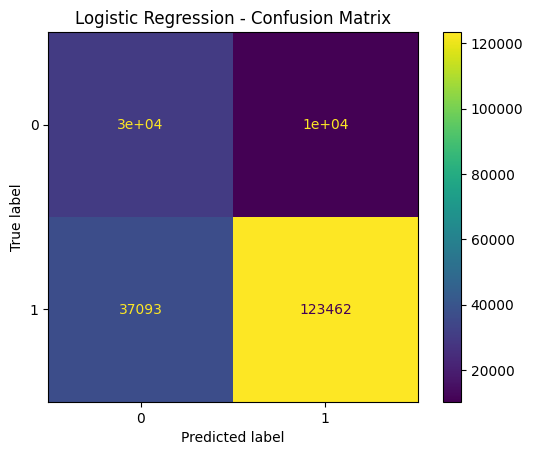

In [ ]:
y_pred_lr = lr_model.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


In [ ]:
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.45      0.74      0.56     40047
           1       0.92      0.77      0.84    160555

    accuracy                           0.76    200602
   macro avg       0.68      0.76      0.70    200602
weighted avg       0.83      0.76      0.78    200602



In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [ ]:
# Predict probability for positive class
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]


In [ ]:
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")


Logistic Regression ROC-AUC: 0.8228


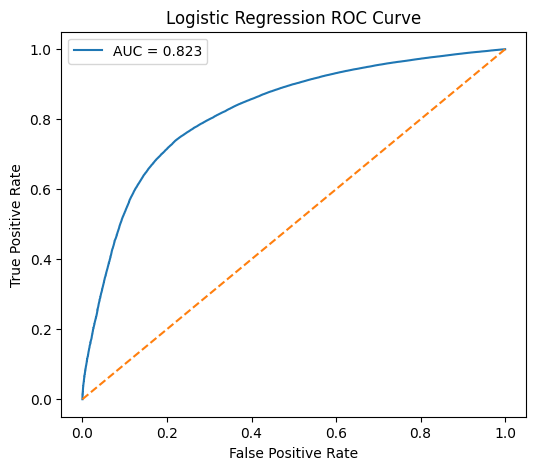

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_lr:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.show()


In [ ]:
import shap


In [ ]:
masker = shap.maskers.Independent(X_train)


In [ ]:
explainer_lr = shap.Explainer(
    lr_model,
    masker
)


In [ ]:
shap_values_lr = explainer_lr.shap_values(X_test)


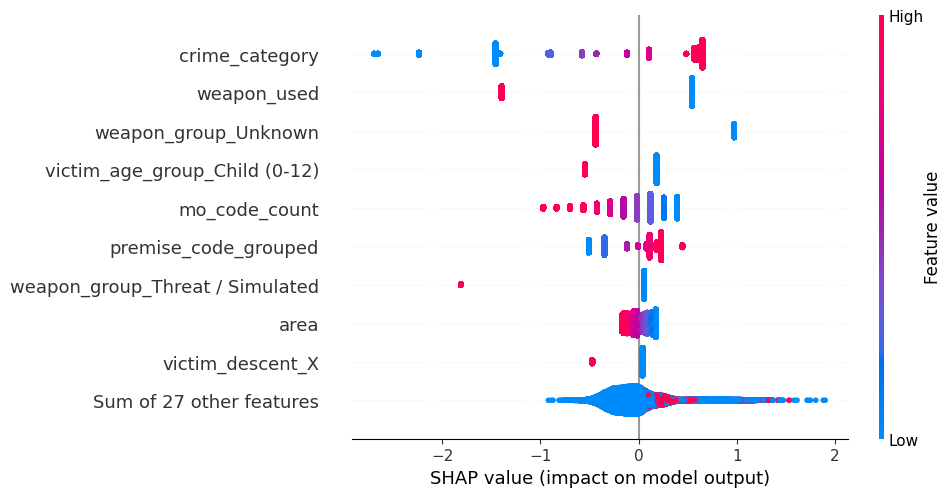

In [ ]:
import shap
import numpy as np

# Ensure shap_values_lr is a 2D numpy array and cast to float64
# .squeeze() removes unnecessary dimensions (e.g., from (N, M, 1) to (N, M))
values_to_plot = np.array(shap_values_lr).astype(np.float64).squeeze()

exp = shap.Explanation(
    values=values_to_plot,
    data=X_test.values,
    feature_names=X_test.columns.tolist()
)

shap.plots.beeswarm(exp)

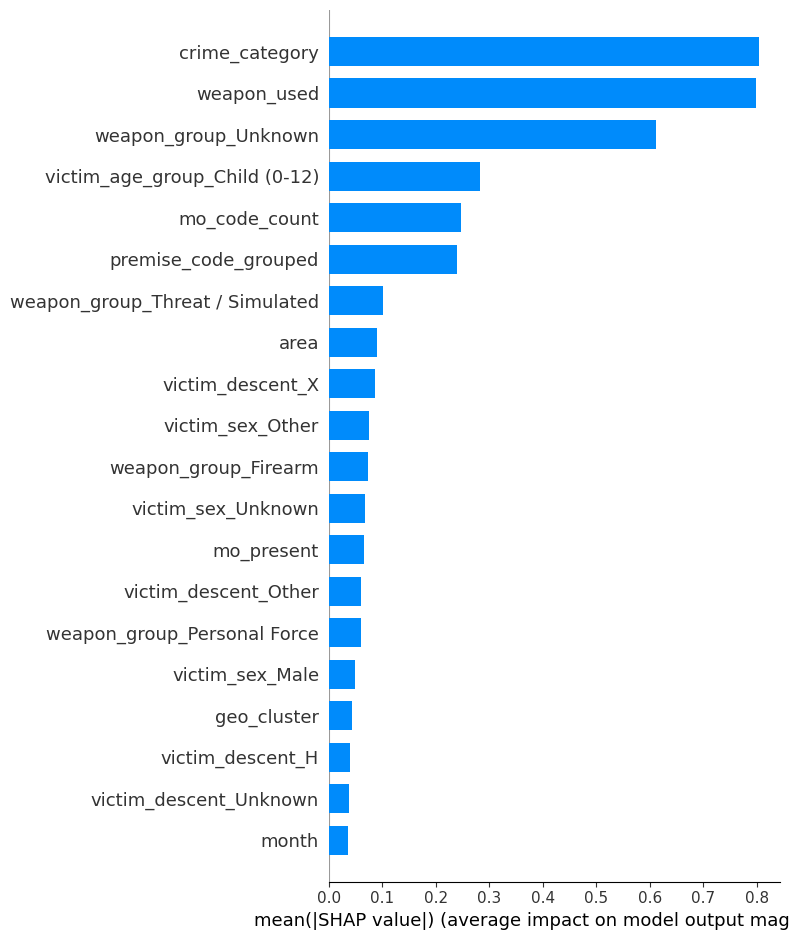

In [ ]:


# SHAP bar plot
shap.summary_plot(
    shap_values_lr,
    X_test,
    feature_names=X_test.columns,
    plot_type="bar"
)



<Figure size 2500x300 with 0 Axes>

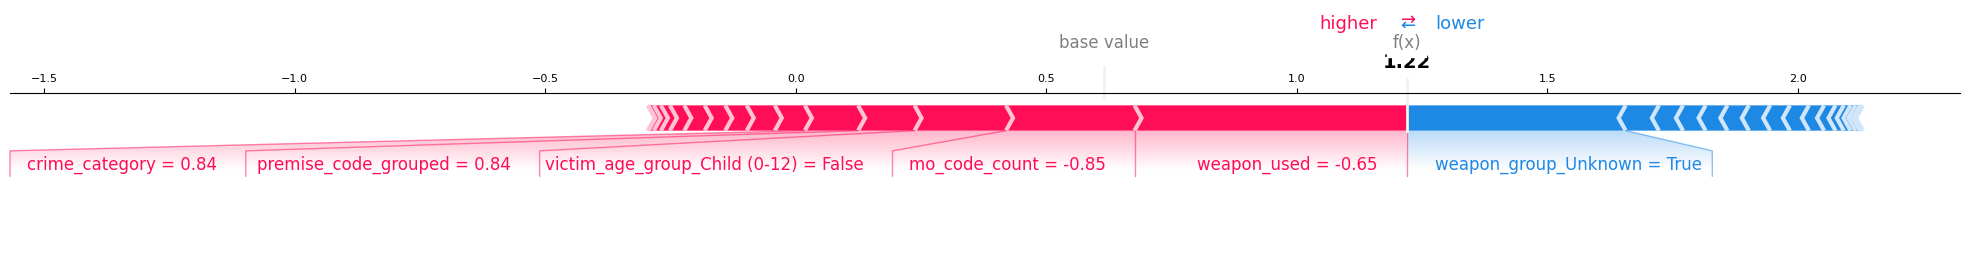

In [ ]:
import matplotlib.pyplot as plt
import shap

# 1. Shorten the data to make labels smaller
# We create a custom Series where values are rounded strings
X_display = X_test.iloc[0:1].copy()
X_display = X_display.round(2).astype(str)

# 2. Set a massive width and a tiny font
plt.rc('font', size=8)          # Decrease global font size
plt.figure(figsize=(25, 3))     # Keep it wide but short

# 3. Plot with the cleaned display data
shap.force_plot(
    explainer_lr.expected_value,
    shap_values_lr[0],
    X_display.iloc[0],         # Use the cleaned/rounded string version
    matplotlib=True,
    show=False,
    contribution_threshold=0.05 # Optional: hide tiny features that clutter the plot
)

# 4. Final visual tweaks
plt.tight_layout()
plt.show()

# Reset font for other plots
plt.rc('font', size=12)

# #Training XG-Boost Second Advanced Model

In [ ]:
from xgboost import XGBClassifier

# Initialize model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:40:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

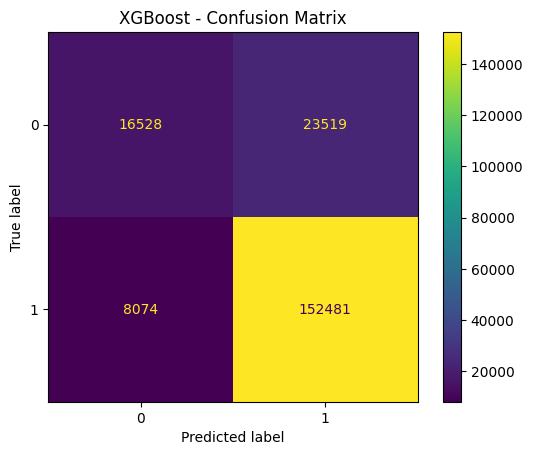

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_xgb = xgb_model.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot()
plt.title("XGBoost - Confusion Matrix")
plt.show()


In [ ]:
# classification Report
from sklearn.metrics import classification_report

print("XGBoost - Classification Report")
print(classification_report(y_test, y_pred_xgb))


XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.67      0.41      0.51     40047
           1       0.87      0.95      0.91    160555

    accuracy                           0.84    200602
   macro avg       0.77      0.68      0.71    200602
weighted avg       0.83      0.84      0.83    200602



XGBoost ROC-AUC: 0.8560


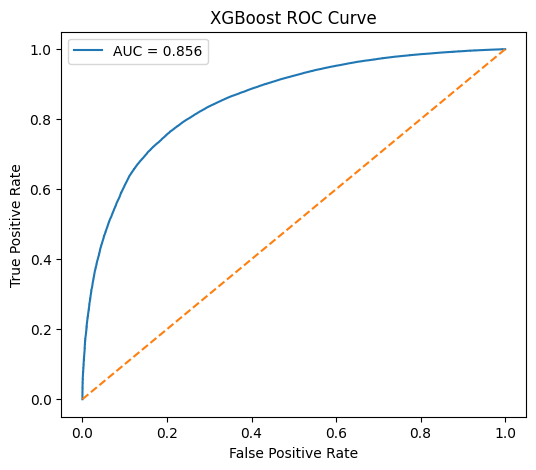

In [ ]:
# ROC Curve + AUC
from sklearn.metrics import roc_auc_score, roc_curve

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost ROC-AUC: {roc_auc_xgb:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_xgb:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()


In [ ]:
# SHAP Explanation (TreeExplainer for XGBoost
import shap

# Create explainer
explainer_xgb = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values_xgb = explainer_xgb.shap_values(X_test)


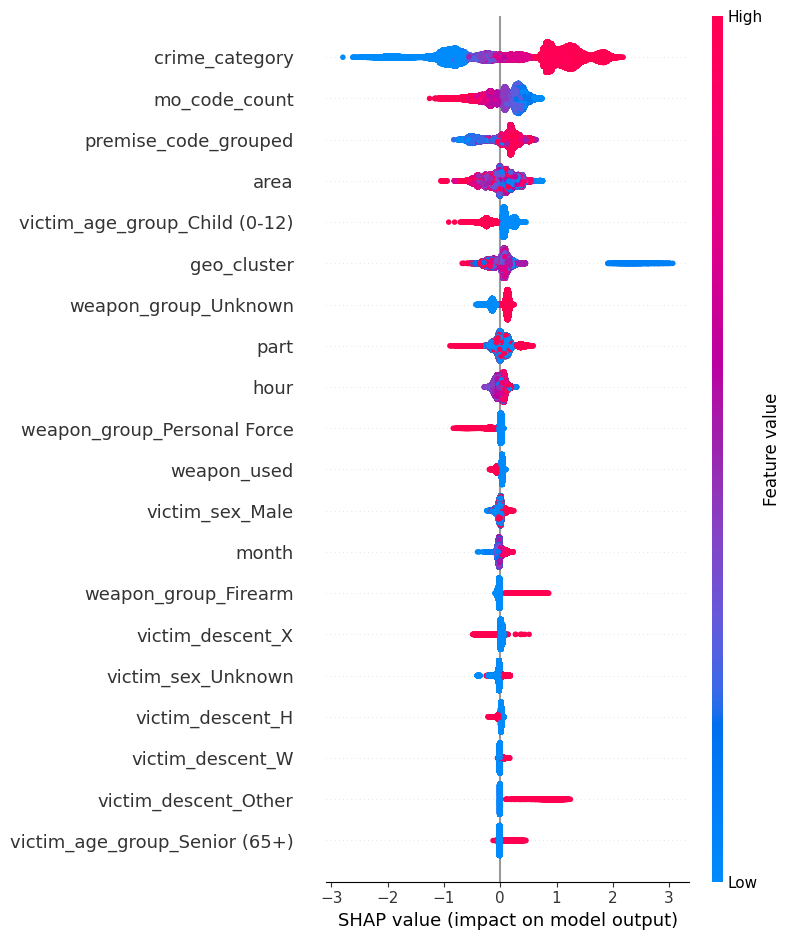

In [ ]:
# SHAP Beeswarm Plot
shap.summary_plot(
    shap_values_xgb,
    X_test,
    feature_names=X_test.columns
)


<Figure size 2000x300 with 0 Axes>

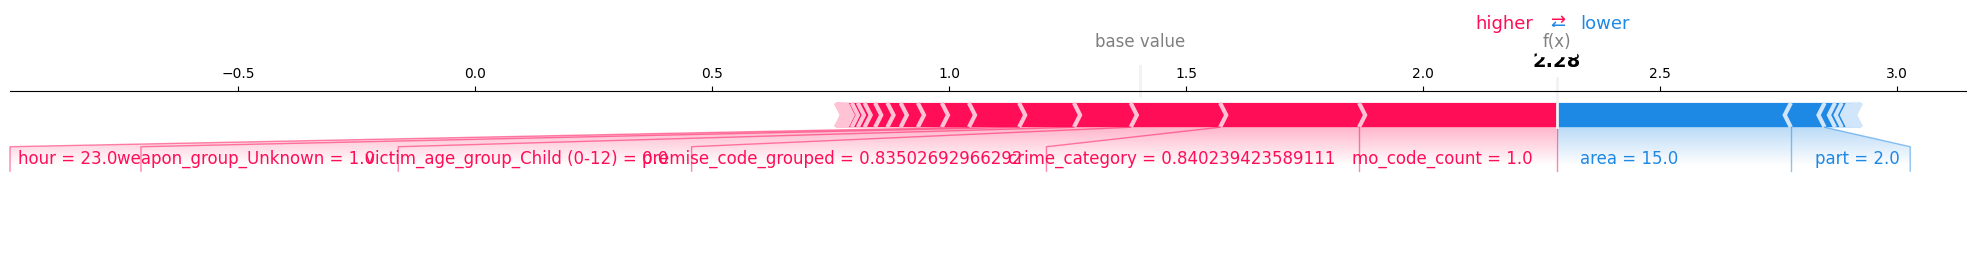

In [ ]:
# SHAP Force Plot (Single Instance)
plt.figure(figsize=(20, 3))

shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[0],
    X_test.iloc[0],
    matplotlib=True,
    show=False
)

plt.tight_layout()
plt.show()
